# Data explorer for NWIS Time Series data

S.M. Richard 2018-08-02

NWIS is the National Water Information System, with data on surface and groundwater in the USA.
This notebook uses data delivered in a sort of standardized tab-delimited text format 'rdb'.  
Documentation for the format is at 
https://waterdata.usgs.gov/nwis/?tab_delimited_format_info  
and   
https://pubs.usgs.gov/of/2003/ofr03123/6.4rdb_format.pdf  
updates: https://help.waterdata.usgs.gov/news/June-10-2016  

Actual data (see the example URLs included below in one of the cells) shows some variability in conformance to the spec, and also probably reflect evolution of the spec over time.

Important pattern is header in the text file with lines beginning with '#' character; 

* Header:  
The header section contains zero or more lines with information such as disclaimers, sites, parameter and location names. 
The header comment lines start with a sharp sign (#) followed by (one or more...) space character followed by any text desired.

* Column-name row:  
The header is followed by exactly one tab-delimited column-name row. The fields in the tab-delimited column-name row contain the names of each column.

* Column definition row:  
This is followed by exactly one column-definition row.  The fields in the tab-delimited column-definition row contain the data definitions and optional column documentation for each column.

* Data section:  
Then is the data section consisting of any number of rows of tab-delimited data fields. Data rows must have exactly the same number of tab-delimited columns as both the column-name and column-definition rows. Null data values are allowed. 

NWIS data urls are like https://nwis.waterdata.usgs.gov/{state}/nwis/{dataseries}?site_no={siteIDstring}
the {state} part of the host name is optional, can be left out when site_no is provided; it uses standard two character state-name abbreviations (e.g. md, ca, nv...)
{dataseries} is a string identifying NWIS data categories. I haven't found a definitive list, but these are the ones I've figured out:
    * uv -- current data 
    * gwlevels -- groundwater levels
    * peak -- peak stream flow at gage
    * inventory -- site information. No time series information, but useful for location information
    * measurements -- streamflow data for site; https://help.waterdata.usgs.gov/output-formats#streamflow_measurement_data. data files do not include the variable names in header
    
This notebook takes an NWIS site_no as the URL parameter, and determines what data are available for the site 
url like:
* {notebook host}/NWIS-explore2.ipynb?dataurl=https://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=07373420

Note-- seems that selecting 'Cell/Run All' doesn't properly execute the javascript in the first cell of the 'Prepare Data' section below, you have to run that manually, then it will pick up the dataurl from the URL parameters that opened the notebook.

In [33]:
#imports
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import urllib.request

from ipywidgets import widgets  
from IPython.display import display
from IPython.display import clear_output

#import numpy as np
#import json
#import helpers
#import sys
#from IPython import get_ipython
#import matplotlib.patches as mpatches
#import matplotlib.dates as mdates
#import urllib
#from matplotlib import pylab
#from pylab import *
#from datetime import datetime, date, time
#import warnings

#initialize some variables
dataurl='init'

# Utility functions

In [27]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [28]:
def getmetavalue(rdbdata, label,skipVal=-1):
    '''
    function to look for a text string in a text string
    input is a list of text string; 
    searches each string for string containing the 'label' string
    returns the following text, with '- ' and leading/trailing spaces removed
    .
    '''
    inlabel=''
    #first have to handle column names that are parameter numbers
    if label.split('_')[0].isnumeric():
        inlabel=label
        label = label.split('_')[0]

    
    rowcount=0
#    for line in rdbdata:
#        rowcount=rowcount+1
#    print('file lines: ' + str(rowcount))
#    return('nothing')
#    print('getmetadatavalue for ' + label)
    for line in rdbdata:
        strline = str(line)
        #print('line:' + strline)
        if (label in strline):
            out= strline.split(label)[1]
            out = out.strip()
            if (strline[1:2]=='- '):
                out = strline.split('- ')[1]
            if (len(inlabel) == 0):
                return(out)
            else:
                if (inlabel[-3:]=='_cd'):
                    return(out+' code')
                else:
                    return(out)
        rowcount=rowcount+1
        if (skipVal > 0 and rowcount>skipVal): 
            return('Field not documemented')
    return('Field not documemented')



# Prepare Data:

In [29]:
%%javascript
function getQueryStringValue (key){  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("dataurl='".concat(getQueryStringValue("dataurl")).concat("'"));

IPython.notebook.kernel.execute("site_no='".concat(getQueryStringValue("site_no")).concat("'"));
//get the URL parameters and pass to python

<IPython.core.display.Javascript object>

In [34]:
# Some example URLS included here for various NWIS data

if (dataurl=='init'):
    print('No URL parameter')
    # for testing without URL parameter
    
    # Water Quality Samples for the Nation
    #dataurl = 'https://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=07373420&format=rdb'
    #dataurl = 'https://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=07373420&pm_cd_compare=Greater%20than&format=rdb'
    #site_no='07373420'
    
    # groundwater levels
    #dataurl = 'http://nwis.waterdata.usgs.gov/pa/nwis/gwlevels?site_no=400650075514001&agency_cd=USGS&format=rdb'
    # note this gets same result (no '/pa' in URL):
    #dataurl = 'https://nwis.waterdata.usgs.gov/nwis/gwlevels?site_no=400650075514001&agency_cd=USGS&format=rdb'
    #site_no='400650075514001'
    
    # current conditions
    #dataurl = 'https://waterdata.usgs.gov/nwis/uv/?site_no=06191000&format=rdb'
    #site_no='06191000'
    
    #peak stream flow service
    #dataurl = 'https://nwis.waterdata.usgs.gov/nwis/peak/?site_no=01063310&agency_cd=USGS&format=rdb'
    #site_no='01063310'
    
    #site information:
    #dataurl = 'https://waterdata.usgs.gov/nwis/inventory/?site_no=06022500&format=rdb'
    #site_no='06022500'
    

    # site measurements, rdb expanded, works in most cases but doesn't always add more columns:
    dataurl = 'https://waterdata.usgs.gov/nwis/measurements?site_no=08158810&format=rdb_expanded'
    site_no='08158810'
    

else:
    dataurl= dataurl + '&agency_cd=USGS&format=rdb'

No URL parameter


# Data loader
if there are alot of records for this site, this can take awhile, be patient.

In [35]:
# Get the data

from tqdm import tqdm
#for i in tqdm(range(10000)):

print(dataurl)
print('Downloading the dataset. Please wait...')

data = urllib.request.urlopen(dataurl) # it's a file like object and works just like a file
# counter for the number of comment lines at the top of the file
skipVal = 0
datalist=[]
for line in tqdm(data):
    strline = str(line)
    strline = strline.replace("\\r",'')
    strline = strline.replace("\\n",'')
    strline = strline.replace("\'",'')
    #print('line:' + strline)
    if '#' in strline:
        if (strline.find(site_no)>-1):
            site_label=(strline.split('# ')[1].strip())
            #remove extra internal spaces
            site_label = " ".join(site_label.split())
        #print(strline.split('#')[1].strip())
        if (len(strline.split('#')[1].strip()) > 0): 
            out = strline.split('#')[1].strip()
            out = " ".join(out.split())
            #print('output to datalist: ' + out)
            datalist.append(out)
    else:
        break
    skipVal = skipVal + 1
print('Rows to skip: ' + str(skipVal))
global df

print('loading pandas dataframe, Please wait...')
df = pd.read_csv(dataurl, sep='\t',skiprows=range(0, skipVal),encoding='utf-8')

#first row is formatting information, save for later
formats = df.head(1)
#print('formats: ' + str(formats))
#print(str(formats['agency_cd'][0]))
#drop the formatting information row
df = df.drop(df.index[0])
#print(df.info)
print('Ready')

https://waterdata.usgs.gov/nwis/measurements?site_no=08158810&format=rdb_expanded


14it [00:00, 96.53it/s]


Rows to skip: 14
loading pandas dataframe, Please wait...
Ready


In [36]:
df.dtypes

agency_cd                    object
site_no                      object
measurement_nu               object
measurement_dt               object
tz_cd                        object
q_meas_used_fg               object
party_nm                     object
site_visit_coll_agency_cd    object
gage_height_va               object
discharge_va                 object
measured_rating_diff         object
gage_va_change               object
gage_va_time                 object
control_type_cd              object
discharge_cd                 object
chan_nu                      object
chan_name                    object
meas_type                    object
streamflow_method            object
velocity_method              object
chan_discharge               object
chan_width                   object
chan_area                    object
chan_velocity                object
chan_stability               object
chan_material                object
chan_evenness                object
long_vel_desc               

In [37]:
# some data introspection

fielddescriptions={}

for col in tqdm(df.columns):
    mdstring = getmetavalue(datalist, str(col))
    datatype='nan'
    #print('field: ' + str(col) + '. '+ mdstring + '. Format: ' + str(formats[col][0]) )
    if (col[-3:]=='_cd'):
        datatype='code'
    elif (str(formats[col][0])[-1:]=='s'):
        for item in df[col].tolist():
            #print(str(item)+' type ' + str(type(item)))
            if str(item).isnumeric():
                #print('isnumeric')
                datatype='pinteger'
            elif (str(item)!='nan' and is_number(str(item))):
                #print('float')
                datatype='float'
            elif (str(item)!='nan'):
                #print('string')
                datatype='string'
                
    elif (str(formats[col][0])[-1:]=='d'):
        datatype='date'
    elif (str(formats[col][0])[-1:]=='n'):
        datatype='float'
    else:
        datatype='string'
    
    fielddescriptions[col] = {'desc':mdstring, 
                              'format':str(formats[col][0]),
                             'type':datatype}    
    #print(col, fielddescriptions[col])

100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 744.19it/s]


# Graph time series:

X axis will be a time series; for now pick date fields.
  * TBD identify time fields to construct more precise datetime coordinate where applicable

Y axis is choses from numeric or float data type fields identified in the introspection section above.
  * If there is a parm_cd and a result_va field, assume that have soft-typed parameter values (like in NWIS water quality data), add all unique values of parm_cd the pick list for y axis. 
  
Display controls to pick x and y axis, and button to plot the graph  

When the 'plot graph' button is clicked
 * construct the data series 
 * call numpy plot

In [38]:
df.iloc[0]  # get focus on first row of dataframe

display("Number of values in each column",pd.DataFrame(df.count()).transpose().style)


'Number of values in each column'

,agency_cd,site_no,measurement_nu,measurement_dt,tz_cd,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,discharge_va,measured_rating_diff,gage_va_change,gage_va_time,control_type_cd,discharge_cd,chan_nu,chan_name,meas_type,streamflow_method,velocity_method,chan_discharge,chan_width,chan_area,chan_velocity,chan_stability,chan_material,chan_evenness,long_vel_desc,horz_vel_desc,vert_vel_desc,chan_loc_cd,chan_loc_dist
0,306,306,306,306,244,306,305,305,293,305,305,268,197,223,305,305,305,305,305,266,305,265,265,265,305,305,305,305,305,305,305,62


In [39]:
# set up variable options for Y

numfields=["Choose Variable:"]  # this will be the prompt in the drop down box
for col in tqdm(df.columns):
    if ((fielddescriptions[col]['type'] == 'float' 
      or fielddescriptions[col]['type'] == 'pinteger')
        and (df[col].count() > 1)
       and (len(df[col].unique()) > 1)):
        print(df[col].count())
        numfields.append(col+'| '+fielddescriptions[col]['desc'] +
                      '. N=' + str(df[col].count())) 

# CHECK if there is a parameters field, for soft-typed result values
if ('parm_cd' in df.columns.values and 'result_va' in df.columns.values):
    #print('unique param:' + str(len(df['parm_cd'].unique())))
    #print('param %s value count %s' % ('29847', df.loc[df['parm_cd'] == '29847']['result_va'].count()))
    #print(df.loc[df['parm_cd'] == '68530'])
    for aparam in tqdm(df['parm_cd'].unique()):
        try:
            mdstring = getmetavalue(datalist, str(aparam))
            
            valcount = df.loc[df['parm_cd'] == aparam]['result_va'].count()
            if (valcount > 1):
                #print('parameter %s, count %s' % (aparam, valcount))
                numfields.append(str(aparam) + '| ' + mdstring +
                    '. N=' + str(valcount))
        except:
            print('did not find name for parameter ' + str(aparam))
            
    try:
        numfields.remove('result_va| '+fielddescriptions['result_va']['desc'])
    except:
        pass
        
#select x axis
picky = widgets.Dropdown(
    options=numfields,
    description='Numeric field:',
    disabled=False,
    value = 'Choose Variable:'
)

yaxisfield=''

#Describe what happens when the dropdown changes its value
def on_change_y(change):
    global yaxisfield
    if change['type'] == 'change' and change['name'] == 'value':
        #print('change: ' + str(change['new']))
        yaxisfield=change['new'].split('|')[0]
        print('yaxis: %s' % yaxisfield)
    return
        


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

306
293
305
268
197
305
305
265
265
265
62


100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 780.48it/s]


In [40]:
#reformat strings to dates  TBD: look for column names ending in '_dt' and work on those
datefields=["Choose Field"]  #prompt for the drop down list
for col in df.columns:
    if ((col[-3:] == '_dt')
         or (col=='datetime') ):
        #print(col)
        df[col] =  pd.to_datetime(df[col], format='%Y-%m-%d', errors='ignore')
        datefields.append(col)

print(datefields)
# pick the time axis variable, use the date fields
#select x axis
pickx = widgets.Dropdown(
    options=datefields,
    description='Date field for X axis:',
    disabled=False,
    value = 'Choose Field'
)

xaxisfield=''

#Describe what happens when the button changes its value
def on_change_x(change):
    global xaxisfield
    if change['type'] == 'change' and change['name'] == 'value':
        #print('change: ' + str(change['new']))
        xaxisfield=change['new']
        print('xaxis: %s' % xaxisfield)
    return
 

['Choose Field', 'measurement_dt']


In [41]:
#what happens when the button is clicked
def on_button1_clicked(b):
    #clear_output()
    #print("Button clicked.")
    #populate y values
    print('x: %s, y:%s' % (xaxisfield, yaxisfield))
    if (xaxisfield == '' 
        or xaxisfield == 'Choose Field'
        or yaxisfield == ''
        or yaxisfield == 'Choose Variable:'):
        print('Select x and y axis variables before clicking the plot graph button')
        return
        
    #print( ydata)
    try:
        df.dropna()
        df.sort_values(xaxisfield, ascending=True)
        if (yaxisfield in df.columns):
            print('N values df column: %s' % df[yaxisfield].count() )
            #print (df[yaxisfield])
            xval, yval = [],[]
            for idx, val in df[xaxisfield].iteritems():
                if ((str(df[yaxisfield][idx]).lower()!= 'nan')
                   and (isinstance(df[xaxisfield][idx], datetime.datetime))):
                    xval.append(df[xaxisfield][idx])
                    yval.append(float(df[yaxisfield][idx]))
    
            plt.plot(xval,yval)
            plt.xlabel(fielddescriptions[yaxisfield]['desc'])
            plt.title(fielddescriptions[xaxisfield]['desc'])
        #uncomment next two rows to print values plotted
            #for idx in range(0,len(xval)):
            #    print('x: %s, y: %s' % (xval[idx],yval[idx]))
        else:
            df.iloc[0]
            print('N values: %s' % df.loc[df['parm_cd'] == int(yaxisfield)]['result_va'].count() )
            plt.plot(df.loc[df['parm_cd'] == int(yaxisfield)][xaxisfield],
                     df.loc[df['parm_cd'] == int(yaxisfield)]['result_va'])
            plt.xlabel(fielddescriptions[xaxisfield]['desc'])
            plt.title(getmetavalue(datalist, yaxisfield))
        #uncomment next two rows to print values plotted
            #for idx in range(0,len(xval)):
            #    print('x: %s, y: %s' % (xval[idx],yval[idx])

        
    except ValueError:
        print('The column contains a Non-Integer Value! Nothing Can be Displayed!')
    
    return

def on_button2_clicked(b):
    clear_output()
    display(pickx)
    display(picky)
    display(button1)
    display(button2)
    return

Dropdown(description='Date field for X axis:', options=('Choose Field', 'measurement_dt'), value='Choose Field…

Dropdown(description='Numeric field:', options=('Choose Variable:', 'measurement_nu| Field not documemented. N…

Button(description='Plot Time Series', style=ButtonStyle())

Button(description='Clear Display', style=ButtonStyle())

xaxis: measurement_dt
yaxis: chan_velocity
x: measurement_dt, y:chan_velocity
N values df column: 265


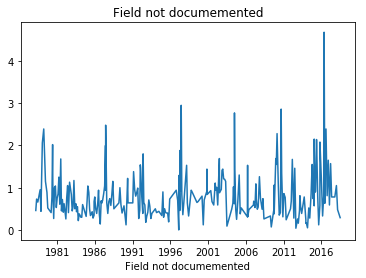

In [42]:
if len(datefields)>1:
    pickx.observe(on_change_x)
    display(pickx)
    picky.observe(on_change_y)
    display(picky)
    
    button1 = widgets.Button(description="Plot Time Series")
    button1.on_click(on_button1_clicked)
    display(button1)

    button2 = widgets.Button(description="Clear Display")
    button2.on_click(on_button2_clicked)
    display(button2)
else:
    print('There are no date fields in this dataset \n Can not plot a time series')
